In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, RepeatVector, Concatenate, Dense, TimeDistributed
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import random

In [2]:
# Load and preprocess data
url = '/kaggle/input/eng-french/eng_-french.csv' 
data = pd.read_csv(url)
data.rename(columns={"English words/sentences": "Eng", "French words/sentences": "Frn"}, inplace=True)


In [3]:
def tokenize_and_pad(texts, max_len=None):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    return padded_sequences, tokenizer

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'])
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'])

eng_max_len = max(len(seq) for seq in eng_sequences)
frn_max_len = max(len(seq) for seq in frn_sequences)

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'], max_len=eng_max_len)
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'], max_len=frn_max_len)

eng_vocab_size = len(eng_tokenizer.word_index) + 1
frn_vocab_size = len(frn_tokenizer.word_index) + 1

train_eng, test_eng, train_frn, test_frn = train_test_split(eng_sequences, frn_sequences, test_size=0.2, random_state=42)



In [58]:
def define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim=128, lstm_units=256):
    # Encoder
    encoder_inputs = Input(shape=(eng_max_len,))
    encoder_embedding = Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_len, mask_zero=True)(encoder_inputs)
    
    # Bidirectional LSTM layer with return_state=True
    encoder_lstm = LSTM(units=512, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5, use_bias=True, kernel_initializer='glorot_uniform')(encoder_input)
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    
    # Concatenate forward and backward hidden states
    context_vector = Concatenate()([forward_h, backward_h])  # Shape: (batch_size, lstm_units * 2)
    
    # Repeat the context vector for each timestep in the decoder
    decoder_inputs = RepeatVector(frn_max_len)(context_vector)  # Shape: (batch_size, frn_max_len, lstm_units * 2)

    # Decoder
    decoder_lstm = LSTM(lstm_units * 2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs)
    decoder_dense = TimeDistributed(Dense(frn_vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model(encoder_inputs, decoder_outputs)
    
    # Compile the model
    initial_learning_rate = 0.1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.5,
        staircase=True
    )
    
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_inputs, encoder_outputs, forward_h, forward_c, backward_h, backward_c

Epoch 1/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 427s 950ms/step - accuracy: 0.8827 - loss: 1.8960 - val_accuracy: 0.8964 - val_loss: 1.6733
Epoch 2/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 419s 952ms/step - accuracy: 0.8961 - loss: 1.6770 - val_accuracy: 0.8964 - val_loss: 1.6733
Epoch 3/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 419s 952ms/step - accuracy: 0.8963 - loss: 1.6752 - val_accuracy: 0.8964 - val_loss: 1.6733
Epoch 4/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 419s 952ms/step - accuracy: 0.8963 - loss: 1.6738 - val_accuracy: 0.8964 - val_loss: 1.6733
Epoch 5/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 419s 952ms/step - accuracy: 0.8963 - loss: 1.6747 - val_accuracy: 0.8964 - val_loss: 1.6733
Epoch 6/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 419s 952ms/step - accuracy: 0.8964 - loss: 1.6727 - val_accuracy: 0.8964 - val_loss: 1.6733
Epoch 7/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 419s 952ms/step - accuracy: 0.8966 - loss: 1.6702 - val_accuracy: 0.8964 - val_loss: 1.6733
Epoch 8/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 419s 952ms/step - accuracy: 0.8964 -

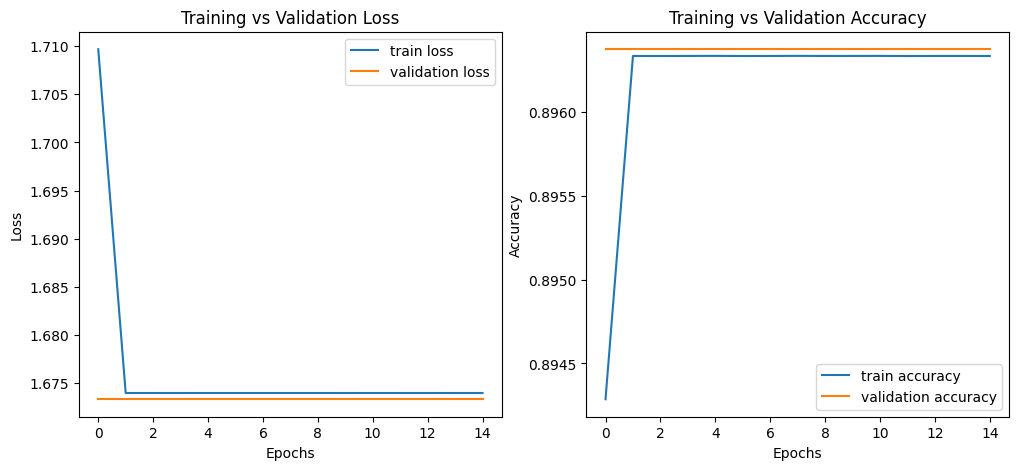

In [16]:
embedding_dim = 128
lstm_units = 256
batch_size = 256
epochs = 15

model = define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim, lstm_units)

# Prepare data for the decoder
train_frn_input = train_frn[:, :-1]  # input 
train_frn_output = train_frn[:, 1:]  # expected output 

# Padding train_frn_input to ensure it matches the required input shape
train_frn_input = pad_sequences(train_frn_input, maxlen=frn_max_len, padding='post')
train_frn_output = pad_sequences(train_frn_output, maxlen=frn_max_len, padding='post')

# Train the model
history = model.fit(train_eng, train_frn_output,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

plt.show()

In [65]:
# Define your parameters
eng_max_len = 20
frn_max_len = 20
eng_vocab_size = 10000
frn_vocab_size = 10000
embedding_dim = 256
hidden_units = 512  # Ensure this is defined before using it

# Define the encoder
encoder_inputs = Input(shape=(eng_max_len,))
encoder_embedding = Embedding(input_dim=eng_vocab_size, output_dim=embedding_dim)(encoder_inputs)
lstm_layer = LSTM(units=hidden_units, return_sequences=True, return_state=True, use_bias=True, use_cudnn=False)
encoder_outputs, forward_h, forward_c = lstm_layer(encoder_embedding)
encoder_model = Model(encoder_inputs, [encoder_outputs, forward_h, forward_c])

# Define the decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=frn_vocab_size, output_dim=embedding_dim)(decoder_inputs)
lstm_layer = LSTM(units=hidden_units, return_sequences=True, return_state=True, use_bias=True, use_cudnn=False)
decoder_outputs, _, _ = lstm_layer(decoder_embedding, initial_state=[forward_h, forward_c])
decoder_dense = Dense(frn_vocab_size, activation='softmax')(decoder_outputs)

# Use the correct variable names for the encoder states
decoder_model = Model([decoder_inputs] + [forward_h, forward_c], decoder_dense)

# Print summaries
encoder_model.summary()
decoder_model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_18 (Embedding)        │ (None, 20, 256)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ [(None, 20, 512),      │     1,574,912 │
│                                 │ (None, 512), (None,    │               │
│                                 │ 512)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,134,912 (15.77 MB)

 Trainable params: 4,134,912 (15.77 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, None, 256) │  2,560,000 │ input_layer_25[2… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_186CL… │ [(None, 20, 512), │          0 │ -                 │
│ (InputLayer)        │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ [(None, None,     │  1,574,912 │ embedding_19[2][… │
│                     │ 512), (None,      │            │ keras_tensor_186… │
│                     │ 512), (None,      │            │ keras_tensor_186… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, None,      │  5,130,000 │ lstm_42[2][0]     │
│                     │ 10000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,264,912 (35.34 MB)

 Trainable params: 9,264,912 (35.34 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
def prepare_tokenizer(texts, special_tokens=None):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    
    if special_tokens:
        # Adding special tokens to tokenizer
        for token in special_tokens:
            tokenizer.word_index[token] = len(tokenizer.word_index) + 1
            tokenizer.index_word[len(tokenizer.word_index) + 1] = token
    
    return tokenizer


eng_tokenizer = prepare_tokenizer(data['Eng'], special_tokens=['<start>', '<end>'])
frn_tokenizer = prepare_tokenizer(data['Frn'], special_tokens=['<start>', '<end>'])

def preprocess_input_sequence(sentence, tokenizer, max_len):
    seq = [tokenizer.word_index.get(word, 0) for word in sentence.split()]
    seq = seq[:max_len] + [0] * (max_len - len(seq))
    return np.array(seq).reshape((1, max_len))

def decode_sequence(input_seq, encoder_model, decoder_model, frn_tokenizer, eng_max_len, frn_max_len):
    # Predict the encoder's state
    states_value = encoder_model.predict(input_seq)
    
    # Initialize the target sequence with the start token
    start_token_index = frn_tokenizer.word_index.get('startseq', 1)  # Use a default value if 'startseq' is missing
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_index
    
    # Initialize variables
    decoded_sentence = ''
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = frn_tokenizer.index_word.get(sampled_token_index, '')
        
        if sampled_token == 'endseq' or len(decoded_sentence) > frn_max_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_token
            
            # Update the target sequence
            target_seq[0, 0] = sampled_token_index
            
            # Update the states
            states_value = [h, c]
    
    return decoded_sentence


print(f"Start token index: {frn_tokenizer.word_index.get('<start>', 'Not Found')}")
print(f"End token index: {frn_tokenizer.word_index.get('<end>', 'Not Found')}")


Start token index: 30661
End token index: 30662


In [74]:
def translate_random_sentences(test_eng, data, encoder_model, decoder_model, frn_tokenizer, eng_max_len, frn_max_len, num_sentences=20):
    for _ in range(num_sentences):
        # Choose a random index
        random_index = random.randint(0, len(data) - 1)
        original_sentence = data['Eng'].iloc[random_index]

        # Preprocess the input sequence
        input_seq = preprocess_input_sequence(original_sentence, eng_tokenizer, eng_max_len)
        
        print(f'Original Sentence: {original_sentence}')
        
        # Translate the sentence
        translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, frn_tokenizer, eng_max_len, frn_max_len)
        
        print(f'Translation: {translated_sentence}\n')

# Example usage:
translate_random_sentences(test_eng, data, encoder_model, decoder_model, frn_tokenizer, eng_max_len, frn_max_len)

Original Sentence: I spoke with her for one hour.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


KeyError: 'startseq'